In [1]:
import bats
import gudhi as gd
import dionysus as dion
import ripser
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm

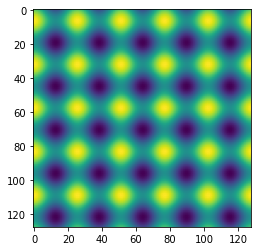

In [2]:
n = 128
img = np.empty((n,n), dtype=np.float64)
for i in range(n):
    for j in range(n):
        img[i,j] = np.sin(10* np.pi * i / n) + np.cos(10* np.pi * j/n)
        
plt.imshow(img)
plt.show()

In [3]:
def kendall_tau_distance(vals1, vals2):
    """
    compute kendall-tau distance between sort permutations for vals1, vals2
    """
    kd = 0
    nmax = 0
    for v1, v2 in zip(vals1, vals2):
        perm1 = np.argsort(v1, kind='stable')
        perm2 = np.argsort(v2, kind='stable')

        nperm = len(perm1)
        maxswaps = (nperm * (nperm-1)) // 2

        kt = bats.kendall_tau(perm1, perm2)
        kd += kt
        nmax += maxswaps
        
    return kd, nmax

def get_kt(img1, img2):
    m, n = img1.shape
    X = bats.Freudenthal(m, n)
    vals, imap = bats.lower_star_filtration(X, img1.flatten())
    vals2, imap = bats.lower_star_filtration(X, img2.flatten())
    kd, nmax = kendall_tau_distance(vals, vals2)
    return kd / nmax

def print_kt(img1, img2):
    print("Kendall-tau distance / max = {}".format(get_kt(img1, img2)))

## Figure 1: Update time by noise level

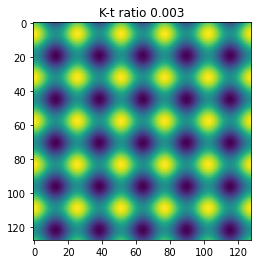

In [4]:
np.random.seed(0)
noise = np.random.randn(n,n)
sigma = 0.01
img2 = img + sigma*noise
# img2 = -img
kt = get_kt(img, img2)
plt.imshow(img2)
plt.title("K-t ratio {:.3f}".format(kt))
plt.show()

In [8]:
sigmas = np.logspace(-4, 1, 10)
kts = []
for sigma in sigmas:
    img2 = img + sigma*noise
    kt = get_kt(img, img2)
    kts.append(kt)
    print("sigma: {:.3e}, kt: {:.3e}".format(sigma, kt))

sigma: 1.000e-04, kt: 3.482e-04
sigma: 3.594e-04, kt: 4.109e-04
sigma: 1.292e-03, kt: 6.665e-04
sigma: 4.642e-03, kt: 1.658e-03
sigma: 1.668e-02, kt: 5.309e-03
sigma: 5.995e-02, kt: 1.821e-02
sigma: 2.154e-01, kt: 5.722e-02
sigma: 7.743e-01, kt: 1.746e-01
sigma: 2.783e+00, kt: 3.646e-01
sigma: 1.000e+01, kt: 4.599e-01


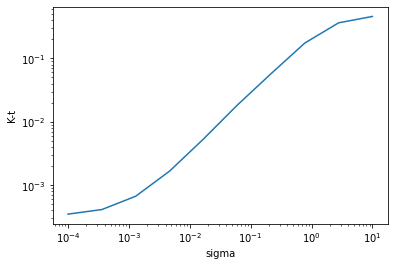

In [9]:
plt.loglog(sigmas, kts)
plt.xlabel('sigma')
plt.ylabel('K-t')
plt.show()

In [10]:
def time_BATS_update(img, img2, *flags):
    m, n = img.shape
    X = bats.Freudenthal(m, n)
    
    # time to compute img1 from scratch
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    # print("img1 from scratch: {} sec.".format(t1 - t0))
    timg1 = t1 - t0
    
    # time to update for img2
    t0 = time.monotonic()
    vals2, imap = bats.lower_star_filtration(X, img2.flatten())
    R.update_filtration(vals2)
    t1 = time.monotonic()
    # print("time to update img2: {} sec.".format(t1 - t0))
    tup = t1 - t0
    
    kd, nmax = kendall_tau_distance(vals, vals2)
    # print("Kendall-tau distance / max = {}".format(kd / nmax))
    kt_ratio = kd / nmax
    
    return timg1, tup, kt_ratio
    
time_BATS_update(img, img2)
print()
time_BATS_update(img2, img)
print("\nwith clearing+basis")
time_BATS_update(img, img2, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
print()
time_BATS_update(img2, img, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())



with clearing+basis



(0.07317528198473155, 0.10611181613057852, 0.45992621215147367)

In [11]:
t1s = [] # time to compute from scratch
u1s = [] # time to update from img2
t2s = [] # time to compute from scratch
u2s = [] # time to update from img1
kts = [] # kendal-tau distance

flags = ()

for sigma in tqdm(sigmas):
    img2 = img + sigma*noise
    t1, u2, kt = time_BATS_update(img, img2, *flags)
    t2, u1, kt = time_BATS_update(img2, img, *flags)
    t1s.append(t1)
    t2s.append(t2)
    u1s.append(u1)
    u2s.append(u2)
    kts.append(kt)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


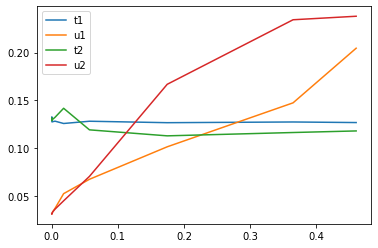

In [12]:
fig, ax = plt.subplots()
ax.plot(kts, t1s, label='t1')
ax.plot(kts, u1s, label='u1')
ax.plot(kts, t2s, label='t2')
ax.plot(kts, u2s, label='u2')
ax.legend()
plt.show(fig)

In [13]:
t1s = [] # time to compute from scratch
u1s = [] # time to update from img2
t2s = [] # time to compute from scratch
u2s = [] # time to update from img1
kts = [] # kendal-tau distance

flags = (bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())

for sigma in tqdm(sigmas):
    img2 = img + sigma*noise
    t1, u2, kt = time_BATS_update(img, img2, *flags)
    t2, u1, kt = time_BATS_update(img2, img, *flags)
    t1s.append(t1)
    t2s.append(t2)
    u1s.append(u1)
    u2s.append(u2)
    kts.append(kt)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]


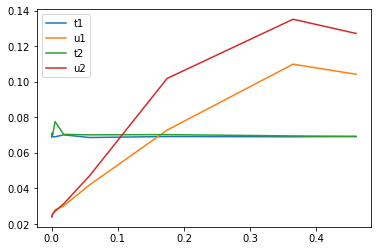

In [14]:
fig, ax = plt.subplots()
ax.plot(kts, t1s, label='t1')
ax.plot(kts, u1s, label='u1')
ax.plot(kts, t2s, label='t2')
ax.plot(kts, u2s, label='u2')
ax.legend()
plt.show(fig)

# Experiment with number of deletions

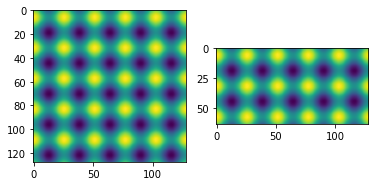

In [15]:
n2 = 64
img2 = np.array(img[:n2], copy=True)
fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(img2)
plt.show()

In [16]:
flags = ()

t0 = time.monotonic()
X1 = bats.Freudenthal(*img.shape)
vals1, imap = bats.lower_star_filtration(X1, img.flatten())
F1 = bats.FilteredSimplicialComplex(X1, vals1)
t1 = time.monotonic()
R1 = bats.reduce(F1, bats.F2(), *flags)
t2 = time.monotonic()
tc1 = t1 - t0
tr1 = t2 - t1

t0 = time.monotonic()
X2 = bats.Freudenthal(*img2.shape)
vals2, imap = bats.lower_star_filtration(X2, img.flatten())
F2 = bats.FilteredSimplicialComplex(X2, vals2)
t1 = time.monotonic()
R2 = bats.reduce(F2, bats.F2(), *flags)
t2 = time.monotonic()
tc2 = t1 - t0
tr2 = t2 - t1

print(tc1, tr1)
print(tc2, tr2)

0.0908103659749031 0.10416023107245564
0.047145540127530694 0.048653237987309694


In [17]:
t0 = time.monotonic()
U12 = bats.UpdateInfoFiltration(F1, F2) # update F1->F2 - delete columns
t1 = time.monotonic()
# R1.update_filtration_general(U12) # perform update, currently crashes
t2 = time.monotonic()
tu1 = t1 - t0
tuc1 = t2 - t1
print(tu1, tuc1)

t0 = time.monotonic()
U21 = bats.UpdateInfoFiltration(F2, F1) # update F2->F1 - add columns
t1 = time.monotonic()
# R2.update_filtration_general(U21) # perform update
t2 = time.monotonic()
tu2 = t1 - t0
tuc2 = t2 - t1
print(tu2, tuc2)

0.023445256985723972 3.775209188461304e-05
0.035884692799299955 3.106705844402313e-05


In [18]:
# this is supposed to work but doesn't
C1 = bats.FilteredF2ChainComplex(F1)
perm1 = C1.perm()
U12.filtered_info(perm1, -1)

In [19]:
# this is supposed to work but doesn't
C2 = bats.FilteredF2ChainComplex(F2)
perm2 = C2.perm()
U21.filtered_info(perm2, -1)

In [22]:
t0 = time.monotonic()
U12 = bats.UpdateInfoFiltration(F1, F2) # update F1->F2 - delete columns
C1 = bats.FilteredF2ChainComplex(F1)
perm1 = C1.perm()
U12.filtered_info(perm1, -1)
t1 = time.monotonic()
R1.update_filtration_general(U12) # perform update, currently crashes
t2 = time.monotonic()
tu1 = t1 - t0
tuc1 = t2 - t1
print(tu1, tuc1)

t0 = time.monotonic()
U21 = bats.UpdateInfoFiltration(F2, F1) # update F2->F1 - add columns
C2 = bats.FilteredF2ChainComplex(F2)
perm2 = C2.perm()
U21.filtered_info(perm2, -1)
t1 = time.monotonic()
R2.update_filtration_general(U21) # perform update
t2 = time.monotonic()
tu2 = t1 - t0
tuc2 = t2 - t1
print(tu2, tuc2)

0.05780382687225938 0.022009696112945676
0.07465794589370489 1.5434621190652251


In [21]:
def print_UI(UI):
    print("UpdateInformation: ", UI)
    print("kt-dists", *UI.kendall_tau_dists)
    print("additions: ", *(len(idxs) for idxs in UI.addition_indices))
    print("deletions: ", *(len(idxs) for idxs in UI.deletion_indices))
    
print_UI(U12)

print_UI(U21)

UpdateInformation:  <bats.topology.UpdateInfoFiltration object at 0x7f068af4ec30>


AttributeError: 'bats.topology.UpdateInfoFiltration' object has no attribute 'kendall_tau_dists'

In [23]:
p1 = R1.persistence_pairs(0)
p2 = R2.persistence_pairs(0)

for p in p1:
    if p.length() > 0.1:
        print(p)

0 : (-1.9988,inf) <2496,-1>
0 : (-1.9988,0) <5824,12543>
0 : (-1.99759,-1.11022e-16) <2445,7158>
0 : (-1.99759,-1.11022e-16) <5773,17090>
0 : (-1.99759,-1.11022e-16) <2547,7236>
0 : (-1.99759,-1.11022e-16) <5875,17168>
0 : (-1.99398,-0.00361073) <2470,7083>
0 : (-1.99398,-0.00361073) <2522,7311>
0 : (-1.99398,-0.00361073) <5798,17015>
0 : (-1.99398,-0.00361073) <5850,17243>
0 : (-1,-0.00481527) <129,2611>
0 : (-0.998795,-0.00361073) <27,2458>
0 : (-0.998795,-0.00361073) <231,2764>
0 : (-0.995185,-2.22045e-16) <181,2689>
0 : (-0.995185,0) <77,2533>
0 : (-0.75702,-0.00481527) <8128,22475>
0 : (-0.755815,-0.00361073) <8077,22322>
0 : (-0.755815,-0.00361073) <8179,22628>
0 : (-0.752205,-1.11022e-16) <8154,22553>
0 : (-0.752205,1.11022e-16) <8102,22397>


In [24]:
for p in p2:
    if p.length() > 0.1:
        print(p)

0 : (-2,inf) <12352,-1>
0 : (-1.9988,0) <2496,12543>
0 : (-1.9988,-0.00120454) <5824,32025>
0 : (-1.9988,-0.00120454) <12301,36572>
0 : (-1.9988,-0.00120454) <12403,36650>
0 : (-1.99759,-1.11022e-16) <2445,7158>
0 : (-1.99759,-1.11022e-16) <5773,17090>
0 : (-1.99759,-1.11022e-16) <2547,7236>
0 : (-1.99759,-1.11022e-16) <5875,17168>
0 : (-1.99518,-0.00481527) <12378,36725>
0 : (-1.99518,-0.00120454) <15680,41957>
0 : (-1.99518,-0.00481527) <9024,22475>
0 : (-1.99518,-0.00481527) <12326,36497>
0 : (-1.99398,-0.00361073) <2470,7083>
0 : (-1.99398,-0.00361073) <2522,7311>
0 : (-1.99398,-0.00361073) <5798,17015>
0 : (-1.99398,-0.00361073) <5850,17243>
0 : (-1.99398,0) <15629,41804>
0 : (-1.99398,-0.00361073) <8973,22322>
0 : (-1.99398,-0.00361073) <9075,22628>
0 : (-1.99398,2.22045e-16) <15731,42110>
0 : (-1.99037,0) <15706,46657>
0 : (-1.99037,1.11022e-16) <8998,22397>
0 : (-1.99037,-1.11022e-16) <9050,22553>
0 : (-1.99037,0) <15654,46429>
0 : (-1,-0.00481527) <129,2611>
0 : (-0.998795,-0.